In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets
import glob

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-io4s62gr because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_closure():
    plt.show()
    #plt.close()

# Dataset

In [3]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [4]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
print(all_points.shape)
all_poses = all_points.reshape(-1,8)

# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
# scaling term doesn't affect time, so don't use time in calculation

mean = np.mean(all_poses, axis=0)
mean[0] = 0 # don't scale time
variance = np.var(all_poses[:,1:], axis=0) # don't scale time
print(mean)
print(variance)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

We found 155 pickup attempts
(155, 64, 8)
[ 0.          0.00227658 -0.00117697  0.0121782  -0.04935249  0.37343377
 -0.89429268 -0.01921521]
[2.63014114e-05 3.40430938e-05 1.00819967e-04 7.90561700e-03
 3.18947674e-02 7.03375426e-03 1.11414372e-02]
std of:  0.17859106200728153


In [5]:
def print_to_csv(mean):
    string = ""
    for i,m in enumerate(mean):
        string += "%0.8f" % m
        if i < len(mean)-1:
            string+= ","
    return string
print(f"\
      mean = np.array(({print_to_csv(mean[1:])}))\n\
      ps = {position_scaling}\n\
      rs = {rotation_scaling}\n")
def scale_dataset(input_points):
    points = input_points - mean
    poss = position_scaling
    rts = rotation_scaling
    points = (points * np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    return points

def unscale_poses(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean[1:]
    return points 
    
def unscale_dataset(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean
    return points

      mean = np.array((0.00227658,-0.00117697,0.01217820,-0.04935249,0.37343377,-0.89429268,-0.01921521))
      ps = 5.599384363139225
      rs = 0.895901498102276



In [6]:
dataset = scale_dataset(all_points)
t_all_points = torch.tensor(dataset,dtype=torch.float32)

## 2D VAE Fit to Dataset

In [7]:
all_models = ['pcamodels/banana_lat3_pca_20220725-203021.npz']

In [8]:
latent_lim_values = np.array((2.,2,2))

In [9]:
modelname = all_models[0]
pca_mod = np.load(modelname)
pca_mean = pca_mod["mean"]
pca_components = pca_mod["pca_components"]

In [10]:
import transforms3d as t3d

In [11]:
def loss_function(numpy_latent,target_angle, verbose=False):
    targ_ang_rads = 0.4 - (target_angle / 180. * np.pi)
    #print(targ_ang_rads)
    latent = numpy_latent.reshape(3,1)
    scaled_pose = pca_components @ latent
    scaled_pose = scaled_pose + pca_mean.reshape(-1,1)
    scaled_pose = scaled_pose.reshape(-1,7)
    pose = unscale_poses(scaled_pose)
    quat = pose[0,3:]
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    eul = np.array(t3d.euler.quat2euler(quat,axes='sxyz'))
    if verbose:
        print(eul * 180/np.pi)
    return np.sum(np.square(eul - (targ_ang_rads,0,-0.79478576)) * np.array((1.,1,1))) # ok for a little side to side, but gotta be correct tilt

In [12]:
# https://pyswarms.readthedocs.io/en/latest/examples/usecases/train_neural_network.html#Constructing-a-custom-objective-function
def loss_function_batch(x, target_angle):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [loss_function(x[i],target_angle) for i in range(n_particles)]
    return np.array(j)

In [13]:
import pyswarms as ps

final_answers = []
for target_ang in [30,45,60]:
    lim = 3
    curbest = None
    while curbest is None:# or (np.sqrt(curbest[0])/np.pi) * 180 > 1: # keep expanding the search radius until within 1 degree of desired angle
        #lim += 0.5
        for _ in range(10):
            # Set-up hyperparameters
            options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

            # Call instance of GlobalBestPSO
            optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=3,
                                                options=options, bounds=((-lim,-lim,-lim),(lim,lim,lim)))

            # Perform optimization
            stats = optimizer.optimize(loss_function_batch, target_angle=target_ang, iters=200)

            if curbest is None or stats[0] < curbest[0]:
                print("updating best")
                curbest = stats
    final_answers.append(curbest)
print(final_answers)

2022-07-25 20:41:13,992 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=6.28e-10
2022-07-25 20:41:14,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.281960470259954e-10, best pos: [0.0074784  0.07647371 0.04549521]
2022-07-25 20:41:14,663 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=3.58e-11
2022-07-25 20:41:15,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.583547652654898e-11, best pos: [0.00748058 0.07647269 0.04550415]
2022-07-25 20:41:15,258 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=3.63e-10
2022-07-25 20:41:15,881 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.6316439236153983e-10, best pos: [0.00748182 0.07648115 0.04550843]
2022-07-25 20:41:15,887 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.24e-9
2022-07-25 20:41:16,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.240937176354703e-09, best pos: [0.00748438 0.07648235 0.04549509]
2022-07-25 20:41:16,613 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.17e-10
2022-07-25 20:41:17,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.1651880192273355e-10, best pos: [0.00748248 0.07647055 0.0455078 ]
2022-07-25 20:41:17,298 - pyswarms

updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.59e-10
2022-07-25 20:41:20,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.5893330653807065e-10, best pos: [0.00747902 0.0764734  0.04551292]
2022-07-25 20:41:20,394 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=6.6e-11 
2022-07-25 20:41:20,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.598433725308948e-11, best pos: [0.00914655 0.0797056  0.18682657]
2022-07-25 20:41:20,988 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=8.44e-10
2022-07-25 20:41:21,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.441305047087987e-10, best pos: [0.00914694 0.0797116  0.18681188]
2022-07-25 20:41:21,580 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.7e-9 
2022-07-25 20:41:22,182 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.695580087615649e-09, best pos: [0.00914843 0.0797227  0.18682207]
2022-07-25 20:41:22,188 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.89e-10
2022-07-25 20:41:22,772 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.885205469944638e-10, best pos: [0.00914589 0.07970481 0.18683213]
2022-07-25 20:41:22,778 - pyswarms.s

updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=4.03e-13
2022-07-25 20:41:24,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.0263614690541705e-13, best pos: [0.00914506 0.07970405 0.18682467]
2022-07-25 20:41:24,737 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=2.49e-11
2022-07-25 20:41:25,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.4852127893835353e-11, best pos: [0.00914612 0.07970445 0.18682532]
2022-07-25 20:41:25,364 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.39e-9
2022-07-25 20:41:25,981 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.391528877813556e-09, best pos: [0.00914073 0.07970469 0.18680816]
2022-07-25 20:41:25,986 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=4.32e-12
2022-07-25 20:41:26,613 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.318217760796636e-12, best pos: [0.00914548 0.07970459 0.18682526]
2022-07-25 20:41:26,620 - pyswarms.

updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.65e-10
2022-07-25 20:41:27,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.6541641068032283e-10, best pos: [0.01089386 0.08310566 0.33531376]
2022-07-25 20:41:27,820 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=3.07e-10
2022-07-25 20:41:28,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.070075252779373e-10, best pos: [0.01089243 0.08310737 0.33531289]
2022-07-25 20:41:28,421 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=5.22e-10
2022-07-25 20:41:28,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.215643855912067e-10, best pos: [0.01089299 0.08308879 0.33530774]
2022-07-25 20:41:28,990 - pyswarms

updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.66e-10
2022-07-25 20:41:30,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.6568231729435204e-10, best pos: [0.01089333 0.08309895 0.33530372]
2022-07-25 20:41:30,797 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=2.6e-11 
2022-07-25 20:41:31,390 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.6002119669982423e-11, best pos: [0.01089478 0.08309962 0.33530831]
2022-07-25 20:41:31,398 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


updating best


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.06e-10
2022-07-25 20:41:31,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0646968769800923e-10, best pos: [0.01089417 0.08310329 0.33531526]
2022-07-25 20:41:31,995 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.3e-10 
2022-07-25 20:41:32,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2957338197824572e-10, best pos: [0.01089559 0.08309966 0.33531631]


[(1.593228236457935e-11, array([0.0074798 , 0.07647154, 0.04550754])), (4.0263614690541705e-13, array([0.00914506, 0.07970405, 0.18682467])), (2.6002119669982423e-11, array([0.01089478, 0.08309962, 0.33530831]))]


In [14]:
for fb in final_answers:
    print(np.sqrt(fb[0]) / np.pi * 180)

0.00022869761196090617
3.63562443028067e-05
0.0002921642065113103


In [15]:
for fb in final_answers:
    print(f"[{','.join([f'{s}' for s in fb[1]])}],")

[0.007479799312754073,0.07647153994825423,0.045507538603075624],
[0.009145061305475446,0.07970404684497107,0.18682466997021463],
[0.010894781291365287,0.08309961915200924,0.33530831118127175],


In [16]:
for fb in final_answers:
    loss_function(fb[1],1000,True)


[-7.08169084e+00 -1.71920776e-04 -4.55380205e+01]
[-2.20816589e+01 -2.11172374e-05 -4.55378739e+01]
[-3.70814478e+01  7.79776841e-05 -4.55377231e+01]


In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [18]:
pca_components.shape

(448, 3)

In [19]:
pca_comps = pca_components.reshape(64,7,3)

In [20]:
pca_mean_comps = pca_mean.reshape(64,7)

<IPython.core.display.Javascript object>


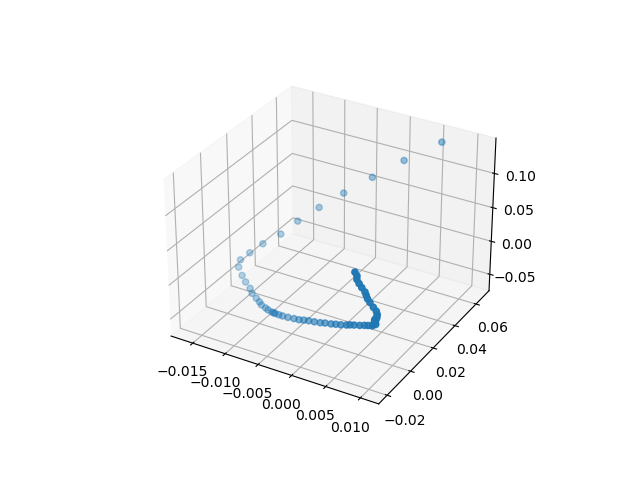

In [21]:
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_mean_comps[:,0],pca_mean_comps[:,1],pca_mean_comps[:,2])